# CNN-LSTM on IAM lines

## Main Resources

- <a id="1">[1]</a> https://github.com/Sagar-modelling/Handwriting_Recognition_CRNN_LSTM
    - Recognizes words     
    - uses a wrapper model to find ctc loss
    - input: (128px,32px), output: sequence of max. 31 characters
    - kinda clear workflow and explanation
- <a id="2">[2]</a> https://github.com/sushant097/Handwritten-Line-Text-Recognition-using-Deep-Learning-with-Tensorflow
    - Recognizes lines of text
    - input: (800px,64px), output: sequence of max 100(?) characters
    - but it's tf v1    
- <a id="3">[3]</a> https://stackoverflow.com/questions/60285167/tensorflow-callback-as-custom-metric-for-ctc
    - CER & WER metrics implemented (has to rewrite them tho)

## Replicate the process

Let's import some libs and define some constants

In [1]:
import cv2, os, math, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
tf.version.VERSION

2024-06-02 14:07:44.267084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 14:07:44.267150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 14:07:44.268679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

In [2]:
characters = " !\"#%&'()*+,-./0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" +"ĂÂÎȘȚăâîșț"
dataset_paths = ["/kaggle/input/flex-iam-lines/IAM_lines/", "/kaggle/input/custom-lines/Custom_lines/"]

IMG_SIZE = (64, 1024)
SEQ_LEN = 100
LOGIT_LEN = 128
np.random.seed(2024)

- ```IMG_SIZE``` is the size of the input images into the network
- ```SEQ_LEN``` is the maximum number of characters that we assume exist on a single line

### Fetching dataset

We are using a customly organized version of the IAM dataset. It consists of a collection of paired files (`n.png`, `n.txt`), where `n` is a natural number. `n.png` is an image containing the cropped line and `n.txt` represents the text written on that line.

In [3]:
"""
Converts a string to an array of labels.
Each character is mapped to an integer label that marks its 
position in the `characters` string.
The resulted array is padded up to `SEQ_LEN` with a constant 
value (has the same value with the so-called "CTC blank label").
"""
def text_to_labels(text:str):
    char_ids = []
    for c in text:
        cid = characters.find(c)
        if cid<0:
            print(f"Warning: undefined character `{c}`")
        else:
            char_ids.append(cid)
    while(len(char_ids)<SEQ_LEN):
        char_ids.append(len(characters))
    return np.array(char_ids)    

In [4]:
"""
Resizes an image to fit into the `IMG_SIZE` bounds, attempting 
to keep aspect ratio if the input is not too wide.
"""
def im_resize(img):
    h, w = img.shape
    H, W = IMG_SIZE
    new_img = cv2.resize(img, (w*H//h, H), interpolation=cv2.INTER_CUBIC)    
    if new_img.shape[1] < W:
        pad_len = W - new_img.shape[1]
        left = math.floor(np.random.rand()*pad_len)
        right = pad_len-left
        new_img = np.pad(new_img, ((0,0), (left, right)), mode="maximum")
    elif new_img.shape[1] > W:
        new_img = cv2.resize(new_img, (W, H))
    return new_img

In [5]:
"""
Increases constrast and makes lines thicker in an image
"""
def enhance(img):
    pxmin = np.min(img)
    pxmax = np.max(img)
    imgContrast = (img - pxmin) / (pxmax - pxmin) * 255    
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(imgContrast, kernel, iterations=1) # increase linewidth

Now we're ready to load the dataset into memory.
- Plain loading as numpy arrays, no generators, no data augmentation for now
- `x_train[i]` represents the input image
- `y_true[i]` represents the (labeled) output of `x_train[i]`
- `y_len[i]` tells the number of (useful/effective) characters in `y_true[i]`, considering that the original strings were all padded up to the same length. This value is needed in computing the CTC loss and is also known as the **label length**

In [6]:
def enumerate_dataset(dataset_path):        
    for root, dirs, files in os.walk(dataset_path, topdown=False):
        for name in files:
            if name.endswith(".png"):            
                img = cv2.imread(os.path.join(root, name), cv2.IMREAD_GRAYSCALE)
                img = enhance(img)                                    
                img = im_resize(img)            
                img = np.reshape(img, IMG_SIZE+(1,))
                with open(os.path.join(root, name[:-4]+".txt"), "r") as f:
                    txt = f.read()
                tlabels = text_to_labels(txt)                        
                y_true = np.array(tlabels)
                d_in = (img/255., y_true, 
                        np.array([len(txt)]), np.array([LOGIT_LEN]))                            
                d_out = (np.array([0]), tf.keras.utils.to_categorical(y_true))
                yield (d_in, d_out)

In [7]:
import itertools
def generator():
    ds1 = [enumerate_dataset(dataset_paths[0]), dataset_paths[0]]
    ds2 = [enumerate_dataset(dataset_paths[1]), dataset_paths[1]]
    
    def itnext(l):
        res = next(l[0], None)
        if res is None:
            l[0] = enumerate_dataset(l[1])
            res = next(l[0], None)
        return res                
    
    while True:
        r = np.random.randint(0,100)
        yield itnext(ds1) if r<95 else itnext(ds2)                            

In [8]:
output_types = ((tf.float32, tf.float32, tf.float32, tf.float32), (tf.float32, tf.float32))
output_shapes = (((64,1024,1), (100,), (1,), (1,)), ((1,), (100, 92)))
train_ds = tf.data.Dataset.from_generator(generator, output_types, output_shapes)
val_ds = tf.data.Dataset.from_generator(generator, output_types, output_shapes)

### Input preview

[38] building has lagged behind the demand.


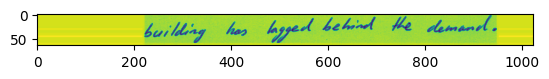

[39] London new towns which cannot be filled


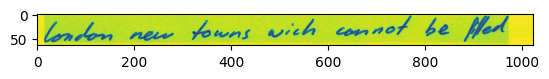

In [9]:
g = generator()
for g in itertools.islice(g, 2):
    (x,y,l,logits), (yt, cat) = g    
    print(l, "".join([characters[c] for c in y if c<len(characters)]))
    plt.imshow(x)
    plt.show()
del g

## Recognition model

The recognition model takes the input through a series of convolutional layers, before finally sending the features to a BiLSTM layer.

In [10]:
def create_recognition_model(img_size, labels_len):               
    x = x_input = tf.keras.layers.Input(shape=(*img_size, 1), name='x_input')
        
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    
    x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)        
        
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    
    x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)                    
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)        
    
    x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)            
    
    # ----- LSTM -----        
    x = tf.keras.layers.Reshape((-1, 512))(x)          
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x)    
    
    x = tf.keras.layers.Reshape((128, 1, -1))(x)
    x = tf.keras.layers.Conv2D(labels_len, kernel_size=(1,1))(x)        
    x = tf.keras.layers.Reshape((-1, labels_len))(x)
    x = tf.keras.layers.Softmax()(x)                
    
    return tf.keras.models.Model(x_input, x)    

In [11]:
recognition_model = create_recognition_model(IMG_SIZE, len(characters)+1)
recognition_model.summary(90)

Model: "model"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 x_input (InputLayer)                   [(None, 64, 1024, 1)]               0             
                                                                                          
 conv2d (Conv2D)                        (None, 64, 1024, 64)                1664          
                                                                                          
 leaky_re_lu (LeakyReLU)                (None, 64, 1024, 64)                0             
                                                                                          
 max_pooling2d (MaxPooling2D)           (None, 32, 512, 64)                 0             
                                                                                          
 conv2d_1 (Conv2D)                      (None, 32, 512, 128)               

- On the same note as `y_train`, we also need a new tensor that provides the number of timestamps for the CTC loss function. We name it `logit_len`

### Training model

We follow the approach from [[1]](#1), where another model is created which incorporates the recognition model and applies the CTC loss on its output using a separate layer. The reason that leads to this complication resides in the fact that the function that computes the loss (namely `ctc_batch_cost`) needs some additional parameters besides the predicted output, like the label and logit length. Also, the real and predicted outputs have different shapes. This was solved by creating a separate layer for computing the loss function and providing the needed arguments as input layers to the network.


In [12]:
def create_train_model(model):
    x_input = tf.keras.layers.Input(shape=model.inputs[0].shape[1:], name='img')
    y_true = tf.keras.layers.Input(shape=(SEQ_LEN,), name='y_true')
    label_len = tf.keras.layers.Input(shape=(1,), name="label_len")    
    logits_len = tf.keras.layers.Input(shape=(1,), name="logits_len")      
    
    y_pred = model(x_input)       
    
    def ctc_layer(data):        
        y_true, y_pred, logit_len, label_len = data               
        return tf.keras.backend.ctc_batch_cost(y_true, y_pred, logit_len, label_len)

    ctc_out = tf.keras.layers.Lambda(ctc_layer, name="ctc")([y_true, y_pred, logits_len, label_len]) 
    
    pred_out = tf.keras.layers.Lambda(lambda x:x, name="pred")(y_pred)
    true_out = tf.keras.layers.Lambda(lambda x:x, name="true")(y_true)
    
    return tf.keras.models.Model([x_input, y_true, label_len, logits_len], [ctc_out, pred_out])    


In [13]:
train_model = create_train_model(recognition_model)

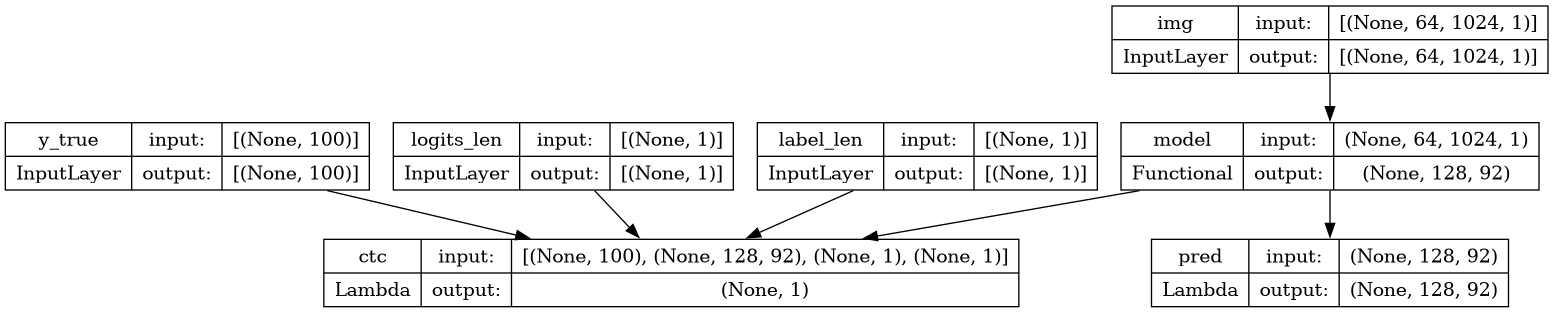

In [14]:
tf.keras.utils.plot_model(train_model, expand_nested=False, show_shapes=True)

The output of the last `Lambda "ctc"` layer will be test against `y_train` values during training. [[1]](#1), the loss function was written as ```lambda y_true, y_pred: y_pred``` (in the given circumstances, this does the same thing as the `MAE` loss, as the "groundtruth" value is always `0`). I also added a projection of the predicted data to compare with the original output, which was converted to a tensor which has the same shape as the output (`y_true_categorical`).

### CER

In [15]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_input_shape = tf.keras.backend.shape(y_pred)
        pred_input_length = tf.ones(shape=pred_input_shape[0]) * tf.keras.backend.cast(pred_input_shape[1], 'float32')
        true_input_shape = tf.keras.backend.shape(y_true)
        true_input_length = tf.ones(shape=true_input_shape[0]) * tf.keras.backend.cast(true_input_shape[1], 'float32')                           
                
        pred, _ = tf.keras.backend.ctc_decode(y_pred, pred_input_length, greedy=True)                
        true, _ = tf.keras.backend.ctc_decode(y_true, true_input_length, greedy=True)        
        
        pred, true = pred[0], true[0]        
        
        pred_length = tf.keras.backend.cast(tf.math.argmin(pred, axis=1), 'int32')
        true_length = tf.keras.backend.cast(tf.math.argmin(true, axis=1), 'int32')                    
        
        pred = tf.keras.backend.ctc_label_dense_to_sparse(pred, pred_length)
        true = tf.keras.backend.ctc_label_dense_to_sparse(true, true_length)
                           
        distance = tf.edit_distance(pred, true, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(tf.cast(pred_input_shape[0],'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

### Prepare for training



In [16]:
train_model.compile(optimizer=tf.keras.optimizers.Adam(0.00025), 
                    loss={
                        'ctc': lambda y_true, y_pred: y_pred                 
                    }, 
                    metrics={
                        'ctc':"accuracy",
                        'pred':[CERMetric()]
                    })

### Training the model

In [17]:
history = train_model.fit(train_ds.shuffle(20).batch(5),                                                     
                          epochs=100,          
                          steps_per_epoch=2800,
                          validation_data=val_ds.batch(1), 
                          validation_steps=300)

Epoch 1/100


I0000 00:00:1717337282.850128     415 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2800/2800 [==============================] - 214s 73ms/step - loss: 52.7387 - ctc_loss: 52.7387 - ctc_accuracy: 7.1429e-05 - pred_CER_metric: 0.3711 - val_loss: 29.3724 - val_ctc_loss: 29.3724 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 0.1996
Epoch 2/100
2800/2800 [==============================] - 204s 73ms/step - loss: 19.5457 - ctc_loss: 19.5457 - ctc_accuracy: 0.0016 - pred_CER_metric: 0.1396 - val_loss: 19.3596 - val_ctc_loss: 19.3596 - val_ctc_accuracy: 0.0067 - val_pred_CER_metric: 0.1348
Epoch 3/100
2800/2800 [==============================] - 206s 74ms/step - loss: 13.8439 - ctc_loss: 13.8439 - ctc_accuracy: 0.0086 - pred_CER_metric: 0.1023 - val_loss: 14.6417 - val_ctc_loss: 14.6417 - val_ctc_accuracy: 0.0033 - val_pred_CER_metric: 0.1007
Epoch 4/100
2800/2800 [==============================] - 204s 73ms/step - loss: 10.8799 - ctc_loss: 10.8799 - ctc_accuracy: 0.0210 - pred_CER_metric: 0.0836 - val_loss: 11.8458 - val_ctc_loss: 11.8458 - val_ctc_accuracy: 0.0267 - 

### Measuring performance

In [30]:
def plot_metric(metric_name):
    plt.plot(history.history[metric_name], label=metric_name)
    plt.plot(history.history[f'val_{metric_name}'], label=f"val_{metric_name}")
    plt.legend()
    plt.show()

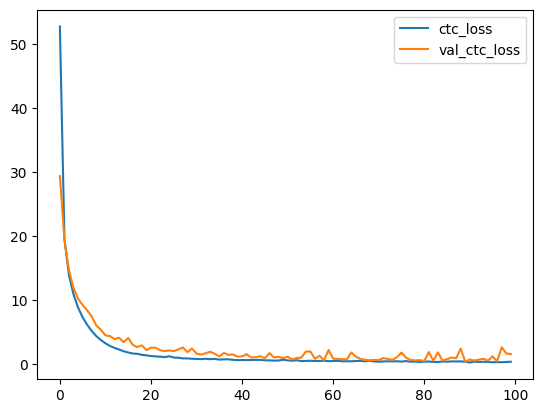

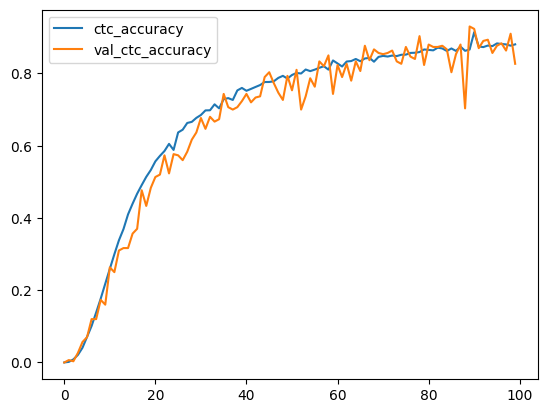

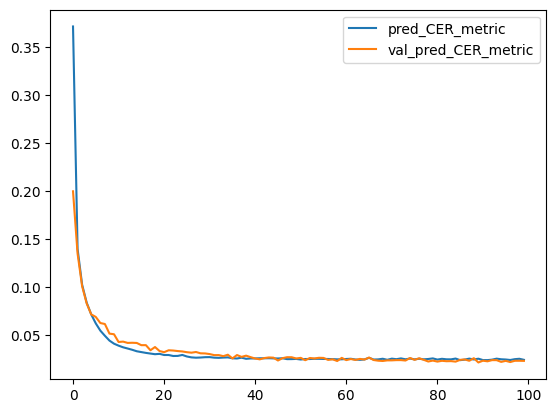

In [31]:
plot_metric("ctc_loss")
plot_metric("ctc_accuracy")
plot_metric("pred_CER_metric")

### Seeing some predictions

1/1 [==============================] - 0s 28ms/step


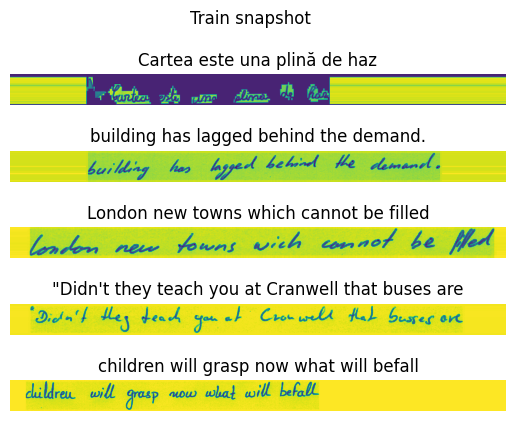

1/1 [==============================] - 0s 25ms/step


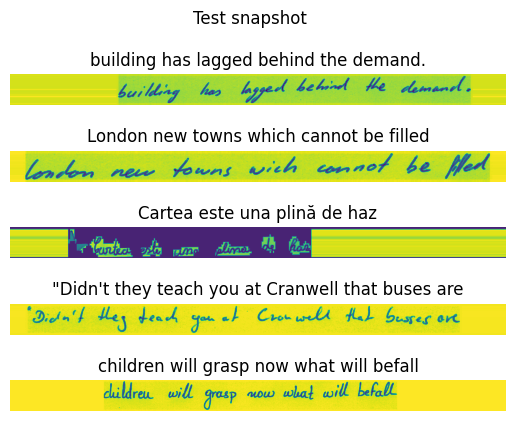

In [32]:
# recognition_model.load_weights('/kaggle/working/model_lstm_fullscale.h5')
def preview_output(x, yt, title):    
    y = recognition_model.predict(x)
    seq_length = recognition_model.output.shape[1]    
    y, _ = tf.keras.backend.ctc_decode(y, np.array([seq_length]*y.shape[0]), greedy=True)
    y=y[0].numpy()        
    n = x.shape[0]
    fig, axs = plt.subplots(n)
    fig.suptitle(title)    

    for i in range(n):
        axs[i].imshow(x[i])
        real_text = "".join([characters[c] for c in y[i] if 0<=c<len(characters)])        
        axs[i].set_title(f"{real_text}")
        axs[i].axis('off')
    plt.show()
    
train_items = list(map(lambda t:(t[0][0].numpy(), t[0][1].numpy()), itertools.islice(train_ds, 5)))
x_train = np.stack(list(map(lambda t:t[0], train_items)))
y_true = np.stack(list(map(lambda t:t[1], train_items)))
preview_output(x_train, y_true, "Train snapshot")
train_items = list(map(lambda t:(t[0][0].numpy(), t[0][1].numpy()), itertools.islice(val_ds, 5)))
x_train = np.stack(list(map(lambda t:t[0], train_items)))
y_true = np.stack(list(map(lambda t:t[1], train_items)))
preview_output(x_train, y_true, "Test snapshot")

### For good measures

In [33]:
recognition_model.save_weights("model_crnn_lstm_weights.h5")
recognition_model.save("model_crnn_lstm.keras")
recognition_model.save("model_crnn_lstm.h5")
recognition_model.save("model_crnn_lstm")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
!zip -r model_crnn_lstm.zip model_crnn_lstm

updating: model_crnn_lstm/ (stored 0%)
updating: model_crnn_lstm/variables/ (stored 0%)
updating: model_crnn_lstm/variables/variables.data-00000-of-00001 (deflated 7%)
updating: model_crnn_lstm/variables/variables.index (deflated 62%)
updating: model_crnn_lstm/saved_model.pb (deflated 90%)
updating: model_crnn_lstm/assets/ (stored 0%)
updating: model_crnn_lstm/fingerprint.pb (stored 0%)
updating: model_crnn_lstm/keras_metadata.pb (deflated 94%)


In [35]:
ls -al

total 163892
drwxr-xr-x 4 root root     4096 Jun  2 19:50 ./
drwxr-xr-x 5 root root     4096 Jun  2 14:04 ../
drwxr-xr-x 2 root root     4096 Jun  2 14:04 .virtual_documents/
-rw-r--r-- 1 root root    59113 Jun  2 14:07 model.png
drwxr-xr-x 4 root root     4096 Jun  2 19:50 model_crnn_lstm/
-rw-r--r-- 1 root root 34003896 Jun  2 19:50 model_crnn_lstm.h5
-rw-r--r-- 1 root root 34021114 Jun  2 19:50 model_crnn_lstm.keras
-rw-r--r-- 1 root root 31732377 Jun  2 19:50 model_crnn_lstm.zip
-rw-r--r-- 1 root root 33991096 Jun  2 19:50 model_crnn_lstm_weights.h5
-rw-r--r-- 1 root root 33991096 Jun  2 14:03 model_lstm_fullscale.h5
